In [1]:
import os
import pickle
import time
import numpy as np
import json
import matplotlib.pyplot as plt
from types import SimpleNamespace

# utils imports
from power_planner.data_reader import DataReader
from power_planner import graphs
from power_planner.plotting import plot_path_costs, plot_pipeline_paths, plot_path, plot_k_sp
from power_planner.utils.utils import get_distance_surface, time_test_csv, compute_pylon_dists, bresenham_line, rescale

In [2]:
PATH_FILES = "../data"

# DEFINE CONFIGURATION
ID = "w_ksp_5"  # str(round(time.time() / 60))[-5:]

OUT_PATH = "outputs/path_" + ID
SCALE_PARAM = 5  # args.scale
# normal graph pipeline
# PIPELINE = [(2, 50), (1, 0)]  # [(1, 0)]  # [(4, 80), (2, 50), (1, 0)]  #
# random graph pipeline
PIPELINE = [(1, 0)]  # [(0.9, 40), (0, 0)]

GRAPH_TYPE = graphs.ImplicitKSP
# LineGraph, WeightedGraph, RandomWeightedGraph, RandomLineGraph, PowerBF
# TwoPowerBF, WeightedKSP
print("graph type:", GRAPH_TYPE)
# summarize: mean/max/min, remove: all/surrounding, sample: simple/watershed
NOTES = "None"  # "mean-all-simple"

IOPATH = os.path.join(PATH_FILES, "ch_dump_" + str(SCALE_PARAM) + ".dat")

with open("../config.json", "r") as infile:
    cfg_dict = json.load(infile)  # Config(SCALE_PARAM)
    cfg = SimpleNamespace(**cfg_dict)
    cfg.PYLON_DIST_MIN, cfg.PYLON_DIST_MAX = compute_pylon_dists(
        cfg.PYLON_DIST_MIN, cfg.PYLON_DIST_MAX, cfg.RASTER, SCALE_PARAM
    )

graph type: <class 'power_planner.graphs.impl_ksp.ImplicitKSP'>
defined pylon distances in raster: 3.0 5.0


In [3]:
# READ DATA
with open(IOPATH, "rb") as infile:
    data = pickle.load(infile)
    (instance, instance_corr, start_inds, dest_inds) = data.data

In [4]:
graph = GRAPH_TYPE(
    instance, instance_corr, graphtool=cfg.GTNX, verbose=cfg.VERBOSE
)

# START PIPELINE
tic = time.time()
corridor = np.ones(instance_corr.shape) * 0.5  # start with all
output_paths = []
plot_surfaces = []
time_infos = []

graph.set_corridor(corridor, start_inds, dest_inds, factor_or_n_edges=1)
print("1) set cost rest")
graph.set_shift(
    cfg.PYLON_DIST_MIN,
    cfg.PYLON_DIST_MAX,
    dest_inds - start_inds,
    cfg.MAX_ANGLE,
    max_angle_lg=cfg.MAX_ANGLE_LG
)
graph.set_edge_costs(
    data.layer_classes, data.class_weights, angle_weight=0.4 # cfg.ANGLE_WEIGHT
)

# add vertices
graph.add_nodes()

1) set cost rest
cost weights [0.28571429 0.23809524 0.23809524 0.23809524]
instance shape (418, 624)
memory taken (dists shape): 7303296


In [5]:
from numba import jit
@jit(nopython=True)
def compute_edge_cost(bres_line, edge_weight, edge_inst):
    if edge_weight == 0:
        return 0
    else:
        edge_cost_list = np.zeros(len(bres_line))
        for k in range(len(bres_line)):
            edge_cost_list[k] = edge_inst[bres_line[k, 0],
                                          bres_line[k, 1]]
        return np.mean(edge_cost_list)


@jit(nopython=True)
def add_in_edges(
    stack, shifts, angles_all, dists, preds, instance, edge_inst, shift_lines,
    edge_weight
):
    """
    Fast C++ (numba) method to compute the cumulative distances from start
    """
    # print(len(stack))
    for i in range(len(stack)):
        v_x = stack[-i - 1][0]
        v_y = stack[-i - 1][1]
        for s in range(len(shifts)):
            neigh_x = v_x + shifts[s][0]
            neigh_y = v_y + shifts[s][1]
            if (
                0 <= neigh_x < dists.shape[1] and 0 <= neigh_y < dists.shape[2]
                and instance[neigh_x, neigh_y] < np.inf
            ):
                # compute edge costs
                edge_cost = compute_edge_cost(shift_lines[s] + np.array([v_x, v_y]), edge_weight, edge_inst)
                # add up costs with angle
                cost_per_angle = dists[:, v_x, v_y] + angles_all[s] + instance[
                    neigh_x, neigh_y] + edge_cost * edge_weight
                dists[s, neigh_x, neigh_y] = np.min(cost_per_angle)
                preds[s, neigh_x, neigh_y] = np.argmin(cost_per_angle)
    return dists, preds

In [6]:
from power_planner.graphs.implicit_lg import topological_sort_jit
tmp_list = graph._helper_list()
visit_points = (graph.instance < np.inf).astype(int)
stack = topological_sort_jit(
    graph.start_inds[0], graph.start_inds[1],
    np.asarray(graph.shifts), visit_points, tmp_list
)

In [31]:
dists_prev, preds_prev = add_in_edges(
    stack, np.array(graph.shifts), graph.angle_cost_array,
    graph.dists, graph.preds, graph.instance, graph.edge_inst,
    graph.shift_lines, 0
)

# New height function

### Load terrain

In [7]:
import rasterio
path_height = "/Users/ninawiedemann/Desktop/thesis/data/Instance_CH.nosync/dtm_10m.tif"
with rasterio.open(path_height, "r") as ds:
    height_rest = ds.read()[0]
    height_rest[height_rest<0] = 200
    print(ds.profile)
height_resistance = np.swapaxes(rescale(height_rest, 5), 1, 0)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 2093, 'height': 3121, 'count': 1, 'crs': CRS.from_epsg(2056), 'transform': Affine(10.0, 0.0, 2598830.2301,
       0.0, -10.0, 1261726.4377), 'tiled': False, 'interleave': 'band'}


### Set constants

In [8]:
# CONSTANTS
# height_resistance
RESOLUTION = 50
# new parameters: H = 6300 lb, w = 1.094 lb/ft = 1.094/0.3048 lb/m = 3.589 lb/m
# previously: (in kg instead of lb)
# CAT_H = 28000
# CAT_W = 15.96
CAT_H = 6300
CAT_W = 3.589
MIN_H = 60
MAX_H = 80
# catenary = catenary_y(np.arange(-250, 250+1, 1)) # hängt ca 17.5 durch


In [9]:
def get_bline_heights(pAx, pAy, pBx, pBy, S):
    """
    Compute bresenham line and return heights
    """
    # distance between points
    b_line = bresenham_line(pAx, pAy,pBx, pBy)
    height_bline = [height_resistance[i,j] for (i,j) in b_line]
    # print(height_bline)
    dists_bline = [int(i*S/len(b_line)) for i in range(len(b_line))]
    return height_bline, dists_bline
# min_heights(catenary, height_bline, dists_bline, 250)

def catenary_y(x):
    return (CAT_W*x**2)/(2*CAT_H) # same as formula from article -> H is the tension

def old_lowest_point(S, h):
    Hw = CAT_H/CAT_W
    hwsinh = Hw * np.sinh(0.5*S/Hw)
    sinpart = np.arcsinh(0.5*h/hwsinh)
    return 0.5*S-Hw*sinpart

def lowest_point(S, h):
    return S/2 - (h*CAT_H/(CAT_W*S))
    # return max([0, min([200, S/2 - (h*CAT_H/(CAT_W*S))])])

### Check whether 60, higher, or not possible

In [10]:
@jit(nopython=True)
def check_edge_heights(
    stack, shifts, height_resistance, shift_lines, height_arr
):
    # print(len(stack))
    for i in range(len(stack)):
        v_x = stack[-i - 1][0]
        v_y = stack[-i - 1][1]
        
        # so far height on in edges
        for s in range(len(shifts)):
            neigh_x = v_x + shifts[s][0]
            neigh_y = v_y + shifts[s][1]
            
            # get minimum heights of v_x,v_y dependent on incoming edge
            bres_line = shift_lines[s] + np.array([v_x, v_y])
            
            # required heights
            S = int(np.sqrt((v_x-neigh_x)**2 + (v_y-neigh_y)**2)) * RESOLUTION
            
            # left and right point
            yA = height_resistance[v_x, v_y] + MIN_H
            yB = height_resistance[neigh_x, neigh_y] + MIN_H
            
            # compute lowest point of sag
            x0 = S/2 - ((yB-yA)*CAT_H/(CAT_W*S))
            # compute height above x0 at left point
            A_height = (CAT_W*x0**2)/(2*CAT_H)
            # print(height_bline)
            
            # iterate over points on bres_line
            stepsize = S/(len(bres_line)+1)
            heights_above = np.zeros(len(bres_line))
            for k, (i,j) in enumerate(bres_line):
                x = x0-stepsize*(k+1)
                cat = (CAT_W*x**2)/(2*CAT_H)
                heights_above[k] = yA - A_height - height_resistance[i,j] + cat
                    
            # analyse heights_above:
            if np.all(heights_above>=11):
                # whole cable is okay
                fine_60 = 0
            elif np.any(heights_above<-9):
                # would not work with 80 - 80
                fine_60 = 2
            else:
                # somewhere inbetween
                fine_60 = 1
                
            # print(hin_p+hin_r, hout_p+hout_r, shift_here, shift_ind, x0, S)
            height_arr[s, neigh_x, neigh_y] = fine_60
            
    return height_arr
# tic = time.time()
# test = check_edge_heights_jit(stack, graph.shifts, height_resistance, graph.shift_lines, np.zeros(graph.dists.shape))
# print(time.time()-tic)

In [11]:
height_arr = np.zeros(graph.dists.shape)
height_arr = check_edge_heights(
    stack, np.array(graph.shifts), height_resistance,
    graph.shift_lines, height_arr
)
# error for more than 200 or less than 0 case? --> FIX

In [12]:
# BACKUP
backup_height_arr = height_arr.copy()

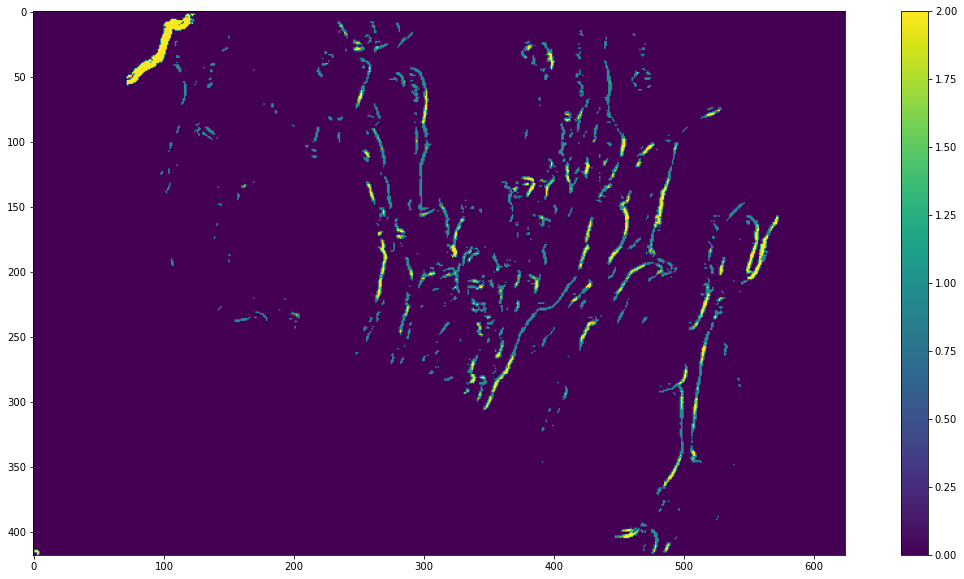

In [13]:
plt.figure(figsize=(20,10))
plt.imshow(np.max(backup_height_arr, axis=0)) # [120:150, 470:490]) # 
plt.colorbar()
plt.show()

### Main function for edge costs

In [14]:
def min_heights(height_bline, dists_bline, S, nr_steps = 5):
    # define height profile of start and dest
    yB = height_bline[-1]
    yA = height_bline[0]
    # left tower 80, right tower 60 and other way round
    x0_right = lowest_point(S, yB+MIN_H - yA-MAX_H)
    x0_left = lowest_point(S, yB+MAX_H - yA-MIN_H)
    # stepsize: all possible positions for x0 / nr_steps
    stepsize = (x0_right-x0_left)//(nr_steps-1)
    height_combinations = np.zeros((nr_steps,2))
    for s in range(nr_steps):
        start = int(s*stepsize - x0_right)
        # base height
        base_height = (CAT_W * start**2)/(2*CAT_H)
        # compute heights of the catenary
        heights_catenary = [catenary_y(d+start)-base_height for i, d in enumerate(dists_bline)]
        # subtract height profile
        heights_above = [height_bline[i] - cat_h for i, cat_h in enumerate(heights_catenary)]
        # compute minimum uplift: each point must be 11 above, so taking the maximum uplift anyway +11
        min_uplift = 11 + np.max(heights_above)
        # the zero point x0 must be at (absolute above sea) height min_uplift.
        # thus, pylon A must be at min_uplift + heights_above[0], and then subtract to get the added part
        min_height_A = min_uplift + heights_catenary[0] - yA
        min_height_B = min_uplift + heights_catenary[-1] - yB
        if min_height_A > MAX_H or min_height_B > MAX_H:
            min_height_A = np.inf
            min_height_B = np.inf
        # print(start, min_height_A, min_height_B)
        # CHECK:
        # actual_h = min_height_B + yB - min_height_A - yA
        # actual_xr = lowest_point(S, actual_h)
        # print("ACTUAL")
        # print(actual_h, actual_xr)
        # cat_heights = [catenary_y(d-actual_xr) for i, d in enumerate(dists_bline)]
        ## check: 
        # print([cat_h + min_height_A - cat_heights[0] + height_bline[0] - height_bline[i] for i,cat_h in enumerate(cat_heights)])
        height_combinations[s] = [max([min_height_A, MIN_H]), max([min_height_B, MIN_H])]
    return height_combinations

def new_in_edges(
    stack, shifts, angles_all, dists, preds, instance, edge_inst, shift_lines,
    edge_weight, height_arr
):
    """
    Compute the shortest path costs with considering pylon heights
    """
    pred_heights = np.zeros(height_arr.shape)
    # print(len(stack))
    for i in range(len(stack)):
        v_x = stack[-i - 1][0]
        v_y = stack[-i - 1][1]
        
        # so far height on in edges
        heights_in = height_arr[:,v_x,v_y]
        
        # iterate over neighbors
        for s in range(len(shifts)):
            neigh_x = v_x + shifts[s][0]
            neigh_y = v_y + shifts[s][1]
            
            if (
                0 <= neigh_x < dists.shape[1] and 0 <= neigh_y < dists.shape[2]
                and instance[neigh_x, neigh_y] < np.inf
            ):
                # the in edge must have been updated - need to check the ones with dists <inf
                # assert heights_in[s]>=60, "invalid in height"+str(heights_in[s])
                
                # TODO: wrong resistances
                if height_resistance[neigh_x, neigh_y] ==200 or height_resistance[v_x, v_y] ==200:
                    continue
                # edge not possible:
                if height_arr[s, neigh_x, neigh_y]==2:
                    # print("impossible", height_resistance[neigh_x, neigh_y], height_resistance[v_x, v_y])
                    continue
                    
                # compute edge costs
                edge_cost = compute_edge_cost(shift_lines[s] + np.array([v_x, v_y]), edge_weight, edge_inst)
                
                # compute height costs if applicable
                if height_arr[s, neigh_x, neigh_y]==1:
                    # get minimum heights of v_x,v_y dependent on incoming edge
                    bres_line = shift_lines[s] + np.array([v_x, v_y])
                    # with start and end
                    b_line = [[v_x, v_y]] + bres_line.tolist() + [[neigh_x, neigh_y]]
                    # print("bres line", b_line)

                    # required heights

                    (pAx, pAy) = bres_line[0]
                    (pBx, pBy) = bres_line[-1]
                    S = int(np.linalg.norm([v_x-neigh_x, v_y-neigh_y]))*RESOLUTION
                    # print("S", S)
                    # get_bline_heights: pixel-wise height from the resistance surface
                    height_bline = [height_resistance[i,j] for (i,j) in b_line]
                    # print(height_bline)
                    dists_bline = [int(S* i/(len(b_line)-1)) for i in range(len(b_line))]
                    # print("dists_bline", dists_bline)
                    # print("height_bline", height_bline)
                    # get height combinations
                    height_combinations = min_heights(height_bline, dists_bline, S)
                    # print("height_combinations", height_combinations)
                    best_height_costs = []
                    hin_hout = []
                    # TODO: np.all(heights_in==60)
                    for h_in in heights_in:
                        if h_in<MIN_H:
                            # problem: for unseen edges, the in height is zero (from height_arr).
                            # circumvent here by processing them as if they were MIN_H ones, and
                            # later they are not feasible anyways because then dists[THIS, v_x,v_y]=inf
                            h_in = MIN_H
                        # print(h_in)
                        # get the subtracted in height cost
                        h_in_sub = np.array([max([0,h-h_in]) for h in height_combinations[:,0]])
                        # overall costs
                        summed_hinhout = h_in_sub + height_combinations[:,1]
                        # print("summed_hinhout", summed_hinhout)
                        best_height_costs.append(np.min(summed_hinhout))
                        best_hinhout = height_combinations[np.argmin(summed_hinhout)]
                        hin_hout.append([max([h_in, best_hinhout[0]]), best_hinhout[1]])
                        # print(hin_hout[-1])
                        height_in = h_in - height_combinations[:,0]
                        
                    # normalize and subtract the 60 because we don't pay for the base height
                    best_height_costs = (np.array(best_height_costs) - MIN_H)/(MAX_H-MIN_H)
                    hin_hout = np.array(hin_hout)
                    
                    # deal with inf ones
                    if np.all(best_height_costs==np.inf):
                        # only 80-80 works but hasn't been found
                        best_height_costs = 2
                        hin_hout = np.zeros(hin_hout.shape) + MAX_H
                    
                    # put all together:
                    cost_per_angle = dists[:, v_x, v_y] + angles_all[s] + instance[
                        neigh_x, neigh_y] + best_height_costs * height_weight + edge_cost * edge_weight
                    
                    # get best in edge
                    best_in_edge = np.argmin(cost_per_angle)
                    # update the minimum out height of this edge
                    h_in_new, h_out = hin_hout[best_in_edge]
                    # print("updated", h_in_new, h_out, best_height_costs)
                    # print("UPDATED:", best_in_edge, h_in_new, h_out)
                    # height_arr[best_in_edge,v_x,v_y] = h_in_new # TODO: can't do this, need separate
                    pred_heights[s,neigh_x,neigh_y] = max([h_in_new, heights_in[best_in_edge]])
                    height_arr[s,neigh_x,neigh_y] = h_out
                else:
                    height_arr[s,neigh_x,neigh_y] = MIN_H
                    # weighted costs --> height cost is zero
                    cost_per_angle = dists[:, v_x, v_y] + angles_all[s] + instance[
                        neigh_x, neigh_y] + edge_cost * edge_weight
                    best_in_edge = np.argmin(cost_per_angle)
                    # update the in height - here it would be 60, so we do not need to take the max
                    pred_heights[s, neigh_x, neigh_y] = heights_in[best_in_edge] # MIN_H
                
                # set distances and predecessors
                dists[s, neigh_x, neigh_y] = np.min(cost_per_angle)
                preds[s, neigh_x, neigh_y] = best_in_edge
        
    return dists, preds, height_arr, pred_heights

In [15]:
# get height arr (with 0-1-2 entries meaning 60m, higher or infinity)
height_arr = backup_height_arr.copy()
height_weight = 0.4
# set start to 60m
height_arr[:, start_inds[0], start_inds[1]] = 60
# RUN
dists, preds, height_arr, pred_heights = new_in_edges(
    stack, np.array(graph.shifts), graph.angle_cost_array,
    graph.dists, graph.preds, graph.instance, graph.edge_inst,
    graph.shift_lines, 0, height_arr
)

### Compute path

In [16]:
def get_shortest_path(dists,preds,shifts, height_arr, start_inds, dest_inds, ret_only_path=False):
    if not np.any(dists[:, dest_inds[0], dest_inds[1]] < np.inf):
        raise RuntimeWarning("empty path")
    tic = time.time()
    curr_point = dest_inds
    path = [dest_inds]
    # first minimum: angles don't matter, just min of in-edges
    min_shift = np.argmin(dists[:, dest_inds[0], dest_inds[1]])
    # track back until start inds
    heights = []
    while np.any(curr_point - start_inds):
        new_point = curr_point - shifts[int(min_shift)]
        # get new shift from argmins
        heights.append(pred_heights[int(min_shift), curr_point[0], curr_point[1]] - MIN_H)
        if heights[-1]>0:
            print(curr_point)
        min_shift = preds[int(min_shift), curr_point[0], curr_point[1]]
        # print(height_arr[int(min_shift), int(new_point[0]), int(new_point[1])])
        # heights.append(height_arr[int(min_shift), int(new_point[0]), int(new_point[1])]-MIN_H)
        path.append(new_point)
        curr_point = new_point
     
    # check heights output
    print(heights)
    print("sum ", round(np.sum(heights)))
    
    path = np.flip(np.asarray(path), axis=0)
    if ret_only_path:
        return path
    return path

path = get_shortest_path(dists,preds,graph.shifts, height_arr, start_inds, dest_inds)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
sum  0.0


### Plot path on heights

In [36]:
np.max(pred_heights)

79.99878401692706

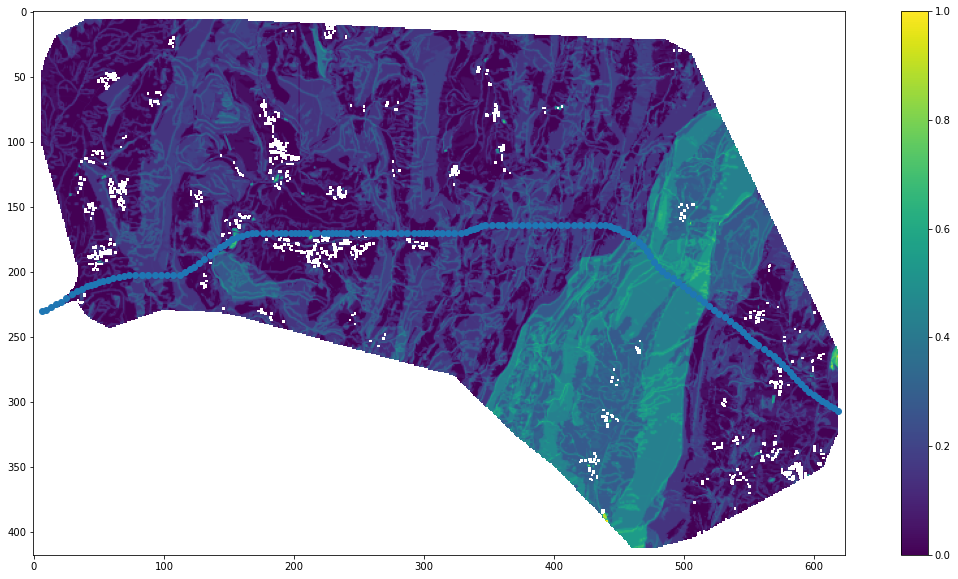

In [33]:
plt.figure(figsize=(20,10))
plt.imshow(graph.instance) # [250:350, 580:]) # np.max(pred_heights, axis=0))
path = np.asarray(path)
plt.scatter(path[:,1], path[:,0])
plt.colorbar()
plt.show()

#### Save path coordinates

In [18]:
data.save_original_path("CH_coords_height_optim", [path], output_coords=True)

## Unit test function of path outputs

In [26]:
shifts_arr = np.asarray(graph.shifts)
bres_line_list = list(graph.shift_lines)
path = np.array(path)
height_prev = 60
for p in range(len(path)-1,0,-1):
    u_x, u_y = path[p-1]
    v_x, v_y = path[p]
    hin_r = height_resistance[u_x,u_y]
    hout_r = height_resistance[v_x,v_y]
    shift_here = path[p] - path[p-1]
    shift_ind = np.argmin([np.linalg.norm(shift_here- s_i) for s_i in shifts_arr])
    hin_p = pred_heights[shift_ind, v_x, v_y]
    hout_p = height_prev
    # print(v_x, v_y, hout_p)
    height_prev = hin_p
    # compute sag
    S = int(np.linalg.norm([v_x-u_x, v_y-u_y]))*RESOLUTION
    x0 = lowest_point(S, hout_p+hout_r - (hin_p+hin_r))
    # if hin_p>50:
    #    print(hin_p, hin_r, hout_p, hout_r, shift_here, shift_ind, x0, S)
    bres_line = np.asarray(bres_line_list[shift_ind])+ path[p-1] # MUST BE CHANGED FOR REV
    stepsize = S/(len(bres_line)+1)
    cat_heights = [catenary_y(x0)]
    overall_heights = []
    for k, (i,j) in enumerate(bres_line):
        actual_height = height_resistance[i,j]
        cat = catenary_y(x0-stepsize*(k+1))
        overall_heights.append(cat + hin_r + hin_p - cat_heights[0] - actual_height) # cat - cat_heights[0] + actual_height)
        # cat_heights.append(cat)
        # cat_heights.append(catenary_y(S-x0))
        # print(cat + hin_r - cat_heights[0] + hin_p - actual_height)
        # yA - A_height - actual_height + cat
        
        if cat + hin_r + hin_p - cat_heights[0] - actual_height<11:
            print(cat + hin_r - cat_heights[0] + hin_p - actual_height)
            print(round(hin_p), round(hin_r), round(hout_p), round(hout_r), round(x0), S, int(backup_height_arr[shift_ind, v_x, v_y]))
            # print("one is fine, just source point artifact")
    # print(bres_line)
    # print("------------")
    # print(round(hin_p+hin_r), round(hout_p+hout_r))
    # print([height_resistance[i,j] for (i,j) in bres_line])
    # print(overall_heights)

## Work on numba speedup

In [81]:
def min_heights(height_bline, dists_bline, S, nr_steps = 5):
    # define height profile of start and dest
    yB = height_bline[-1]
    yA = height_bline[0]
    # left tower 80, right tower 60 and other way round
    x0_right = lowest_point(S, yB+MIN_H - yA-MAX_H)
    x0_left = lowest_point(S, yB+MAX_H - yA-MIN_H)
    # stepsize: all possible positions for x0 / nr_steps
    stepsize = (x0_right-x0_left)//(nr_steps-1)
    height_combinations = np.zeros((nr_steps,2))
    for s in range(nr_steps):
        start = int(s*stepsize - x0_right)
        # base height
        base_height = (CAT_W * start**2)/(2*CAT_H)
        # compute heights of the catenary
        heights_catenary = [catenary_y(d+start)-base_height for i, d in enumerate(dists_bline)]
        # subtract height profile
        heights_above = [height_bline[i] - cat_h for i, cat_h in enumerate(heights_catenary)]
        # compute minimum uplift: each point must be 11 above, so taking the maximum uplift anyway +11
        min_uplift = 11 + np.max(heights_above)
        # the zero point x0 must be at (absolute above sea) height min_uplift.
        # thus, pylon A must be at min_uplift + heights_above[0], and then subtract to get the added part
        min_height_A = min_uplift + heights_catenary[0] - yA
        min_height_B = min_uplift + heights_catenary[-1] - yB
        if min_height_A > MAX_H or min_height_B > MAX_H:
            min_height_A = np.inf
            min_height_B = np.inf
        # print(start, min_height_A, min_height_B)
        # CHECK:
        # actual_h = min_height_B + yB - min_height_A - yA
        # actual_xr = lowest_point(S, actual_h)
        # print("ACTUAL")
        # print(actual_h, actual_xr)
        # cat_heights = [catenary_y(d-actual_xr) for i, d in enumerate(dists_bline)]
        ## check: 
        # print([cat_h + min_height_A - cat_heights[0] + height_bline[0] - height_bline[i] for i,cat_h in enumerate(cat_heights)])
        height_combinations[s] = [max([min_height_A, MIN_H]), max([min_height_B, MIN_H])]
    return height_combinations

def new_in_edges(
    stack, shifts, angles_all, dists, preds, instance, edge_inst, shift_lines,
    edge_weight, height_arr
):
    """
    Compute the shortest path costs with considering pylon heights
    """
    pred_heights = np.zeros(height_arr.shape)
    # print(len(stack))
    for i in range(len(stack)):
        v_x = stack[-i - 1][0]
        v_y = stack[-i - 1][1]
        
        # so far height on in edges
        heights_in = height_arr[:,v_x,v_y]
        
        # iterate over neighbors
        for s in range(len(shifts)):
            neigh_x = v_x + shifts[s][0]
            neigh_y = v_y + shifts[s][1]
            
            if (
                0 <= neigh_x < dists.shape[1] and 0 <= neigh_y < dists.shape[2]
                and instance[neigh_x, neigh_y] < np.inf
            ):
                # the in edge must have been updated - need to check the ones with dists <inf
                # assert heights_in[s]>=60, "invalid in height"+str(heights_in[s])
                
                # TODO: wrong resistances
                if height_resistance[neigh_x, neigh_y] ==200 or height_resistance[v_x, v_y] ==200:
                    continue
                # edge not possible:
                if height_arr[s, neigh_x, neigh_y]==2:
                    # print("impossible", height_resistance[neigh_x, neigh_y], height_resistance[v_x, v_y])
                    continue
                    
                # compute edge costs
                edge_cost = compute_edge_cost(shift_lines[s] + np.array([v_x, v_y]), edge_weight, edge_inst)
                
                # compute height costs if applicable
                if height_arr[s, neigh_x, neigh_y]==1:
                    # get minimum heights of v_x,v_y dependent on incoming edge
                    bres_line = shift_lines[s] + np.array([v_x, v_y])
                    # with start and end
                    b_line = [[v_x, v_y]] + bres_line.tolist() + [[neigh_x, neigh_y]]
                    # print("bres line", b_line)

                    # required heights

                    (pAx, pAy) = bres_line[0]
                    (pBx, pBy) = bres_line[-1]
                    S = int(np.linalg.norm([v_x-neigh_x, v_y-neigh_y]))*RESOLUTION
                    # print("S", S)
                    # get_bline_heights: pixel-wise height from the resistance surface
                    height_bline = [height_resistance[i,j] for (i,j) in b_line]
                    # print(height_bline)
                    dists_bline = [int(S* i/(len(b_line)-1)) for i in range(len(b_line))]
                    # print("dists_bline", dists_bline)
                    # print("height_bline", height_bline)
                    # get height combinations
                    height_combinations = min_heights(height_bline, dists_bline, S)
                    # print("height_combinations", height_combinations)
                    best_height_costs = []
                    hin_hout = []
                    # TODO: np.all(heights_in==60)
                    for h_in in heights_in:
                        if h_in<MIN_H:
                            # problem: for unseen edges, the in height is zero (from height_arr).
                            # circumvent here by processing them as if they were MIN_H ones, and
                            # later they are not feasible anyways because then dists[THIS, v_x,v_y]=inf
                            h_in = MIN_H
                        # print(h_in)
                        # get the subtracted in height cost
                        h_in_sub = np.array([max([0,h-h_in]) for h in height_combinations[:,0]])
                        # overall costs
                        summed_hinhout = h_in_sub + height_combinations[:,1]
                        # print("summed_hinhout", summed_hinhout)
                        best_height_costs.append(np.min(summed_hinhout))
                        best_hinhout = height_combinations[np.argmin(summed_hinhout)]
                        hin_hout.append([max([h_in, best_hinhout[0]]), best_hinhout[1]])
                        # print(hin_hout[-1])
                        height_in = h_in - height_combinations[:,0]
                        
                    # normalize and subtract the 60 because we don't pay for the base height
                    best_height_costs = (np.array(best_height_costs) - MIN_H)/(MAX_H-MIN_H)
                    hin_hout = np.array(hin_hout)
                    
                    # deal with inf ones
                    if np.all(best_height_costs==np.inf):
                        # only 80-80 works but hasn't been found
                        best_height_costs = 2
                        hin_hout = np.zeros(hin_hout.shape) + MAX_H
                    
                    # put all together:
                    cost_per_angle = dists[:, v_x, v_y] + angles_all[s] + instance[
                        neigh_x, neigh_y] + best_height_costs * height_weight + edge_cost * edge_weight
                    
                    # get best in edge
                    best_in_edge = np.argmin(cost_per_angle)
                    # update the minimum out height of this edge
                    h_in_new, h_out = hin_hout[best_in_edge]
                    # print("updated", h_in_new, h_out, best_height_costs)
                    # print("UPDATED:", best_in_edge, h_in_new, h_out)
                    # height_arr[best_in_edge,v_x,v_y] = h_in_new # TODO: can't do this, need separate
                    pred_heights[s,neigh_x,neigh_y] = max([h_in_new, heights_in[best_in_edge]])
                    height_arr[s,neigh_x,neigh_y] = h_out
                else:
                    height_arr[s,neigh_x,neigh_y] = MIN_H
                    # weighted costs --> height cost is zero
                    cost_per_angle = dists[:, v_x, v_y] + angles_all[s] + instance[
                        neigh_x, neigh_y] + edge_cost * edge_weight
                    best_in_edge = np.argmin(cost_per_angle)
                    # update the in height - here it would be 60, so we do not need to take the max
                    pred_heights[s, neigh_x, neigh_y] = heights_in[best_in_edge] # MIN_H
                
                # set distances and predecessors
                dists[s, neigh_x, neigh_y] = np.min(cost_per_angle)
                preds[s, neigh_x, neigh_y] = best_in_edge
        
    return dists, preds, height_arr, pred_heights

46.0

## Thoughts about implementation:

* cannot start from vertex and compute crossing edge costs, because a lot more edges cross one cell than there are shift_lines --> more efficient to directly compute it for each edge
* Store height_in_min and height_out_min for each in-and out-vertex per edge, then update these during add_edges
* don't need to consider cost of h1, only difference of h2 and h3

TODO:

* only one height array, encoding a combination of in and out height?
* use sparse numpy array

So the sparsity has to be less than 1/3 to start saving memory. Obviously you aren't going to save memory if you first build the dense array, and create the sparse one from that.

### NOTE: in the following "in" always means the base of the directed edge and "out" the top

### Compute height constraints per edge

In [ ]:
height_in = np.zeros(dists.shape)
height_out = np.zeros(dists.shape)
for i in range(len(stack)):
    v_x = stack[-i - 1][0]
    v_y = stack[-i - 1][1]
    for s in range(len(shifts)):
        neigh_x = v_x + shifts[s][0]
        neigh_y = v_y + shifts[s][1]
        
        bres_line = shift_lines[s] + np.array([v_x, v_y])
        h_in, h_out = HEIGHT_FUNCTION_HERE(bres_line)
        height_in[s, v_x, v_y] = h_in
        heigh_out[s, neigh_x, neigh_y] = h_out
# NOW: stored for each incoming edge for each vertex the out heights, and for all outgoing edges the in heights

### Then update the min heights

In [ ]:
height_weight = 0.1
for i in range(len(stack)):
    v_x = stack[-i - 1][0]
    v_y = stack[-i - 1][1]
    for s in range(len(shifts)):
        neigh_x = v_x + shifts[s][0]
        neigh_y = v_y + shifts[s][1]
        # get minimum heights of v_x,v_y dependent on incoming edge
        h_in = heigh_out[:,v_x,v_y]
        required_h_in = height_in[:,v_x,v_y]
        # subtract --> this is the cost that must be added for the in edge --> still s entries
        in_costs = required_h_in - h_in # TODO: negative values = 0 (already payer by in edge)
        out_costs = height_out[s,neigh_x,neigh_y]
        # new:
        cost_per_angle = dists[:, v_x, v_y] + angles_all[s] + instance[
            neigh_x, neigh_y] + edge_cost * edge_weight + (in_costs + out_costs) * height_weight
        # previously:
        cost_per_angle = dists[:, v_x, v_y] + angles_all[s] + instance[
            neigh_x, neigh_y] + edge_cost * edge_weight
        dists[s, neigh_x, neigh_y] = np.min(cost_per_angle)
        preds[s, neigh_x, neigh_y] = np.argmin(cost_per_angle)

###  Do both together

In [ ]:
height_arr = np.zeros(dists.shape)

height_weight = 0.1
for i in range(len(stack)):
    v_x = stack[-i - 1][0]
    v_y = stack[-i - 1][1]
    for s in range(len(shifts)):
        neigh_x = v_x + shifts[s][0]
        neigh_y = v_y + shifts[s][1]
        # get minimum heights of v_x,v_y dependent on incoming edge
        bres_line = shift_lines[s] + np.array([v_x, v_y])
        # required heights
        required_h_in, h_out = HEIGHT_FUNCTION_HERE(bres_line)
        # so far height on in edges
        h_in = heigh_arr[:,v_x,v_y]
        # subtract --> this is the cost that must be added for the in edge --> still s entries
        in_costs = required_h_in - h_in # TODO: negative values = 0 (already payer by in edge)
        # update the minimum out height of this edge
        height_arr[s,neigh_x,neigh_y] = h_out
        # put all together:
        cost_per_angle = dists[:, v_x, v_y] + angles_all[s] + instance[
            neigh_x, neigh_y] + edge_cost * edge_weight + (in_costs + h_out) * height_weight
        dists[s, neigh_x, neigh_y] = np.min(cost_per_angle)
        preds[s, neigh_x, neigh_y] = np.argmin(cost_per_angle)

## Develop formula

In [11]:


def get_heights(heigh_bline, dists_bline, S):
    height_profile = np.zeros(S+1) + np.min(height_bline)
    height_profile[dists_bline] = height_bline
    height_profile[0] = height_bline[0]
    height_profile[-1]  = height_bline[-1]
    return height_profile

In [5]:
def catenary_y(x, H=28000, w=15.96):
    Hw = H/w
    return (w*x**2)/(2*H)

def min_height(cable, height_profile):
    return np.min(cable-height_profile)
    # heights_above = [centered_sag[d]-height_bline[i] for i, d in enumerate(dists_bline)]
    
def comp_min_height(height_profile, h, S):
    x_r = int(lowest_point(S, h))
    cat_cable = precomputed_catenary[cat_range-x_r:S-x_r+cat_range+1]
    return np.min(cat_cable+y_A-D_r - height_profile)

In [215]:
cat_range = 500
precomputed_catenary = catenary_y(np.arange(-cat_range, cat_range+1, 1))

In [ ]:
# hyperparameters
RESOLUTION = 10
MIN_PYLON_HEIGHT = 60
# set x points
pA = (1000, 1000)
pB = (1035, 1035)
# derive distance S
(pAx, pAy) = pA
(pBx, pBy) = pB
S = int(np.linalg.norm([pAx-pBx, pAy-pBy]))*RESOLUTION
# define height profile from bline
height_bline, dists_bline = get_bline_heights(pAx, pAy,pBx, pBy, S)
height_profile = get_heights(height_bline, dists_bline, S)
print(len(height_profile))
# height_profile = np.random.rand(S+1)*50

# find lowest point given two pylon heights
y_A=MIN_PYLON_HEIGHT + height_profile[0]
y_B=MIN_PYLON_HEIGHT + height_profile[-1]
x_r = int(lowest_point(S, y_B-y_A))
print(cat_range-x_r, S-x_r+cat_range)
# print([catenary_y(x_i) for x_i in x])
cat_cable = precomputed_catenary[cat_range-x_r:S-x_r+cat_range+1]
D_r = np.max([cat_cable[0], cat_cable[-1]])
cat_cable = cat_cable + y_A - D_r
print("min height", min_height(cat_cable, height_profile))
# min_height(height_profile, y_B-y_A, S))
# print("end points", cat_cable)
plt.plot(np.arange(len(cat_cable)), cat_cable)
plt.plot(height_profile)

In [115]:
def check_60(cat_cable, height_bline, dists_bline, min_height=11):
    heights_above = [cat_cable[d]-height_bline[i] for i, d in enumerate(dists_bline)]
    return np.min(heights_above)>11

In [217]:
centered_sag = precomputed_catenary[250:750]
centered_sag = centered_sag+60-np.max(centered_sag)

In [218]:
heights_above = [centered_sag[d]-height_bline[i] for i, d in enumerate(dists_bline)]

In [219]:
x_r = int(lowest_point(S, y_B-y_A))

In [220]:
height_profile[0]+80

537.8748779296875

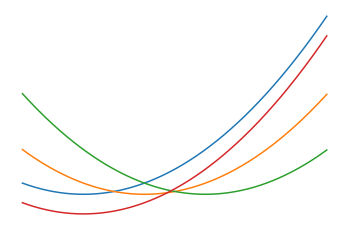

In [228]:
plt.plot(precomputed_catenary[400:900])
plt.plot(precomputed_catenary[300:800])
plt.plot(precomputed_catenary[200:700])
plt.plot(precomputed_catenary[400:900]-5)
plt.axis("off")
plt.savefig("../../figure/catenaries.pdf")

In [96]:
len(catenary)

501

## Backup

### Without jit:

In [ ]:
def check_edge_heights(
    stack, shifts, height_resistance, shift_lines, height_arr
):
    # print(len(stack))
    for i in range(len(stack)):
        v_x = stack[-i - 1][0]
        v_y = stack[-i - 1][1]
        
        # so far height on in edges
        heights_in = height_arr[:,v_x,v_y]
        for s in range(len(shifts)):
            neigh_x = v_x + shifts[s][0]
            neigh_y = v_y + shifts[s][1]
            
            # get minimum heights of v_x,v_y dependent on incoming edge
            bres_line = shift_lines[s] + np.array([v_x, v_y])
            # with start and end
            b_line = [[v_x, v_y]] + bres_line.tolist() + [[neigh_x, neigh_y]]
            # print("bres line", b_line)
            
            # required heights
            S = int(np.linalg.norm([v_x-neigh_x, v_y-neigh_y]))*RESOLUTION
            # print("S", S)
            # get_bline_heights: pixel-wise height from the resistance surface
            height_bline = [height_resistance[i,j] for (i,j) in b_line]
            # print(height_bline)
            dists_bline = [int(S* i/(len(b_line)-1)) for i in range(len(b_line))]
            
            yA = height_bline[0] + MIN_H
            yB = height_bline[-1] + MIN_H
            x0 = lowest_point(S, yB-yA)
            # print(yA, yB, S, x0)
            A_height = catenary_y(x0)
            # print(height_bline)
            
            stepsize = S/(len(bres_line)+1)
            # fine_60 = 1
            # cat_heights = [catenary_y(x0)]
            heights_above = np.zeros(len(bres_line))
            for k, (i,j) in enumerate(bres_line):
                actual_height = height_resistance[i,j]
                cat = catenary_y(x0-stepsize*(k+1))
                heights_above[k] = yA - A_height - actual_height + cat
                # cat_heights.append(cat)
                # cat_heights.append(catenary_y(S-x0))
                # print(round(yA - A_height - actual_height + cat), x0-stepsize*(k+1), round(actual_height))
                if yA - A_height - actual_height + cat <11:
                    # print(S, x0, yA, yB, actual_height)
                    # print(height_bline)
                    # print("yA", round(yA), "x0", x0, "A height", round(A_height), "point x height", round(actual_height), "x cat", round(cat), "yB", round(yB))
                    fine_60 = 0
                    # break
                    
            # analyse heights_above:
            if np.all(heights_above>=11):
                # whole cable is okay
                fine_60 = 0
            elif np.any(heights_above<-9):
                # would not work with 80 - 80
                fine_60 = 2
            else:
                # somewhere inbetween
                fine_60 = 1
                
            # print(hin_p+hin_r, hout_p+hout_r, shift_here, shift_ind, x0, S)
            height_arr[s, neigh_x, neigh_y] = fine_60
            
    return height_arr
            # heights_catenary = [catenary_y(d+start) for i, d in enumerate(dists_bline)]

#### Before merging check and computation

In [ ]:
def catenary_y(x):
    return (CAT_W*x**2)/(2*CAT_H) # same as formula from article -> H is the tension

def old_lowest_point(S, h):
    Hw = CAT_H/CAT_W
    hwsinh = Hw * np.sinh(0.5*S/Hw)
    sinpart = np.arcsinh(0.5*h/hwsinh)
    return 0.5*S-Hw*sinpart

def lowest_point(S, h):
    return S/2 - (h*CAT_H/(CAT_W*S))
    # return max([0, min([200, S/2 - (h*CAT_H/(CAT_W*S))])])

def min_heights(catenary, height_bline, dists_bline, S, nr_steps = 5):
    # define height profile of start and dest
    yB = height_bline[-1]
    yA = height_bline[0]
    # left tower 80, right tower 60 and other way round
    x0_right = lowest_point(S, yB+MIN_H - yA-MAX_H)
    x0_left = lowest_point(S, yB+MAX_H - yA-MIN_H)
    # stepsize: all possible positions for x0 / nr_steps
    stepsize = (x0_right-x0_left)//(nr_steps-1)
    height_combinations = np.zeros((nr_steps,2))
    for s in range(nr_steps):
        start = int(s*stepsize - x0_right)
        # compute heights of the catenary
        heights_catenary = [catenary_y(d+start) for i, d in enumerate(dists_bline)]
        # subtract height profile
        heights_above = [height_bline[i] - cat_h for i, cat_h in enumerate(heights_catenary)]
        # compute minimum uplift: each point must be 11 above, so taking the maximum uplift anyway +11
        min_uplift = 11 + np.max(heights_above)
        # the zero point x0 must be at (absolute above sea) height min_uplift.
        # thus, pylon A must be at min_uplift + heights_above[0], and then subtract to get the added part
        min_height_A = min_uplift + heights_catenary[0] - yA
        min_height_B = min_uplift + heights_catenary[-1] - yB
        # print(start, min_height_A, min_height_B)
        # CHECK:
        # actual_h = min_height_B + yB - min_height_A - yA
        # actual_xr = lowest_point(S, actual_h)
        # print("ACTUAL")
        # print(actual_h, actual_xr)
        # cat_heights = [catenary_y(d-actual_xr) for i, d in enumerate(dists_bline)]
        ## check: 
        # print([cat_h + min_height_A - cat_heights[0] + height_bline[0] - height_bline[i] for i,cat_h in enumerate(cat_heights)])
        
        height_combinations[s] = [max([min_height_A, MIN_H]), max([min_height_B, MIN_H])]
    return height_combinations

def new_in_edges(
    stack, shifts, angles_all, dists, preds, instance, edge_inst, shift_lines,
    edge_weight, height_arr
):
    # print(len(stack))
    for i in range(len(stack)):
        v_x = stack[-i - 1][0]
        v_y = stack[-i - 1][1]
        
        # so far height on in edges
        heights_in = height_arr[:,v_x,v_y]
        for s in range(len(shifts)):
            neigh_x = v_x + shifts[s][0]
            neigh_y = v_y + shifts[s][1]
            
            if (
                0 <= neigh_x < dists.shape[1] and 0 <= neigh_y < dists.shape[2]
                and instance[neigh_x, neigh_y] < np.inf
            ):
                # edge not possible:
                if height_arr[s, neigh_x, neigh_y]==2:
                    print("impossible", height_resistance[neigh_x, neigh_y], height_resistance[v_x, v_y])
                    continue
                    
                if height_arr[s, neigh_x, neigh_y]==1:
                    
                
                # compute edge costs
                edge_cost = compute_edge_cost(shift_lines[s] + np.array([v_x, v_y]), edge_weight, edge_inst)
                # add up costs with angle
                cost_per_angle = dists[:, v_x, v_y] + angles_all[s] + instance[
                    neigh_x, neigh_y] + edge_cost * edge_weight
                
                
                dists[s, neigh_x, neigh_y] = np.min(cost_per_angle)
                preds[s, neigh_x, neigh_y] = np.argmin(cost_per_angle)
            
            # get minimum heights of v_x,v_y dependent on incoming edge
            bres_line = shift_lines[s] + np.array([v_x, v_y])
            # with start and end
            b_line = [[v_x, v_y]] + bres_line.tolist() + [[neigh_x, neigh_y]]
            # print("bres line", b_line)
            
            # required heights

            (pAx, pAy) = bres_line[0]
            (pBx, pBy) = bres_line[-1]
            S = int(np.linalg.norm([v_x-neigh_x, v_y-neigh_y]))*RESOLUTION
            # print("S", S)
            # get_bline_heights: pixel-wise height from the resistance surface
            height_bline = [height_resistance[i,j] for (i,j) in b_line]
            # print(height_bline)
            dists_bline = [int(S* i/(len(b_line)-1)) for i in range(len(b_line))]
            # print("dists_bline", dists_bline)
            # print("height_bline", height_bline)
            # get height combinations
            height_combinations = min_heights(catenary, height_bline, dists_bline, S)
            # print("height_combinations", height_combinations)
            # minimum height is sufficient:
            if np.any(np.all(height_combinations==np.array([MIN_H, MIN_H]), axis=1)):
                # print("all combinations are fine")
                h_cost_final = 0
                best_height_costs = MIN_H
                h_out = MIN_H
                hin_hout = np.swapaxes(np.vstack([heights_in, [MIN_H for _ in range(len(heights_in))]]), 1, 0)
            else:
                best_height_costs = []
                hin_hout = []
                for h_in in heights_in:
                    # print(h_in)
                    # get the subtracted in height cost
                    h_in_sub = np.array([max([0,h-h_in]) for h in height_combinations[:,0]])
                    # overall costs
                    summed_hinhout = h_in_sub + height_combinations[:,1]
                    # print("summed_hinhout", summed_hinhout)
                    best_height_costs.append(np.min(summed_hinhout))
                    best_hinhout = height_combinations[np.argmin(summed_hinhout)]
                    hin_hout.append([max([h_in, best_hinhout[0]]), best_hinhout[1]])
                    # print(hin_hout[-1])
                    height_in = h_in - height_combinations[:,0]
                best_height_costs = np.array(best_height_costs)
            # TODO: if edge can't be placed, continue
            # required_h_in, h_out = HEIGHT_FUNCTION_HERE(bres_line, h_in)
            # subtract --> this is the cost that must be added for the in edge --> still s entries
            # in_costs = required_h_in - h_in # TODO: negative values = 0 (already payer by in edge)
            # put all together:
            cost_per_angle = dists[:, v_x, v_y] + angles_all[s] + instance[
                neigh_x, neigh_y] + best_height_costs * height_weight # (in_costs + h_out)
            # + edge_cost * edge_weight # FOR NOW LEFT OUT
            best_in_edge = np.argmin(cost_per_angle)
            # update the minimum out height of this edge
            h_in_new, h_out = np.array(hin_hout)[best_in_edge]
            # print("UPDATED:", best_in_edge, h_in_new, h_out)
            height_arr[best_in_edge,v_x,v_y] = h_in_new # TODO: can't do this, need separate
            height_arr[s,neigh_x,neigh_y] = h_out
            
            dists[s, neigh_x, neigh_y] = np.min(cost_per_angle)
            preds[s, neigh_x, neigh_y] = best_in_edge
        
    return dists, preds, height_arr